# Decision Tree (CART)
##### Aeon Williams, CS398 F2020

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn import preprocessing #for encoding the categorical data
from sklearn.model_selection import train_test_split #for splitting the dataset

import seaborn as sb

# Decision Tree Algorithm

### Gini Index calculation
<img src="gini_index.PNG" alt="gini_index_formula" width="400"/>

In [4]:
# Calculates the Gini Index of a list of groups (group of rows from the dataset)
def gini_index(row_group, ind_var_values):
    # The number of independent variable instances in the entire group
    feature_total = float(sum([len(group) for group in row_group]))
    gini_index = 0
    
    # Calculate the Gini Index of each individual row, and add that to the total index calculation
    for group in row_group:
        # The number of independent variables instances in this group
        total = float(len(group))
        
        # Calculate the Gini Index of each individual attribute
        if total != 0: # Prevent division by 0
            score = 0
            for value in ind_var_values:
                p = [row[-1] for row in group].count(value) / total
                score += p**2
            gini_index += (1 - score) * (total / feature_total)
            
    return gini_index

### Split groups based on Gini Index
<img src="split_1.PNG" alt="gini_index_formula" width="400"/>

In [5]:
# Splits a list of rows into left and right lists based on given index and value
def split_row_list(feature_index, value, row_list):
    left, right = list(), list()
    
    # If the feature value of the row is less than the given parameter, it goes in the left list
    # Otherwise, it goes into the right list
    for row in row_list:
        if row[feature_index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Determine the best* split of a list of rows
# *a smaller Gini Index is a more cost effective split, quantifying it as best
def best_split(row_list):
    ind_var_values = list(set(row[-1] for row in row_list))
    # Starting values so that the first split is "best", and all other splits iterate off of that one
    result_index = result_value = result_score = 999
    result_groups = ()
    
    # For each feature index in the list
    for feature_index in range(len(row_list[0]) - 1):
        # For each combination of feature and value of that feature
        for row in row_list:
            # Split the list into 2 groups
            row_groups = split_row_list(feature_index, row[feature_index], row_list)
            g_index = gini_index(row_groups, ind_var_values)
            # If the Gini Index from this split is better than the previous recorded best, update all relevant values
            if g_index < result_score:
                result_index, result_value, result_score, result_groups = feature_index, row[feature_index], g_index, row_groups
                
    return {'index':result_index, 'value':result_value, 'groups':result_groups}


### Terminal node
<img src="termination.PNG" alt="gini_index_formula" width="400"/>

In [6]:
# Calculates the most common independent variable value in a list of rows
# This translates to being the prediction value if this terminal node is reached
def terminal_node_value(row_list):
    outcomes = [row[-1] for row in row_list]
    return max(set(outcomes), key=outcomes.count)

### Node creation with splits
<img src="split.PNG" alt="gini_index_formula" width="400"/>

In [7]:
# Create left and right nodes for the given parent node
# This recursive function, when called with a root node, creates an entire decision tree from that information
def build_tree_nodes(node, max_depth, min_size, current_depth):
    # Store the node's groups into relevant left & right lists
    left, right = node['groups']
    del(node['groups'])
    
    # If neither group has anything in it, this is a stopping condition and terminal nodes are created
    if not left or not right:
        node['left'] = node['right'] = terminal_node_value(left + right)
        return
    # If we have reached maximum depth of the tree, this is a stopping condition and terminal nodes are created
    if current_depth >= max_depth:
        node['left'], node['right'] = terminal_node_value(left), terminal_node_value(right)
        return

    nodes, i = [left, right], 0
    for direction in ['left', 'right']:
        # If there aren't enough rows in the group, this is a stopping condition and terminal nodes are created
        if len(nodes[i]) <= min_size:
            node[direction] = terminal_node_value(nodes[i])
        # Otherwise, continue building the tree by splitting
        else:
            node[direction] = best_split(nodes[i])
            build_tree_nodes(node[direction], max_depth, min_size, current_depth+1)
        i += 1

### Build a tree with nodes
<img src="tree.PNG" alt="gini_index_formula" width="500"/>

In [8]:
# Create a decision tree for the given list of rows
def build_tree(row_list, max_depth, min_size):
    # Determine the root node with the first split
    root = best_split(row_list)
    # Build the tree based on the root node
    build_tree_nodes(root, max_depth, min_size, 1)
    return root

### Predictions based on the tree

In [9]:
# Predict the value of the independent variable of the given row
# "node" should be the root node of the tree
def predict(node, row):
    # Determine direction (left or right) to move down, based on how the split functions were written
    # Left
    if row[node['index']] < node['value']:
        # If node is not terminal, continue moving down the tree
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        # Otherwise, we have reached a terminal node, whose value is now the prediction
        else:
            return node['left']
    # Right
    else:
        # If node is not terminal, continue moving down the tree
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        # Otherwise, we have reached a terminal node, whose value is now the prediction
        else:
            return node['right']

## Decision Tree (CART)

In [10]:
# Based on a dataset, pre-divided into train and test sets, predict the independent variable values for the test set
def decision_tree_predictions(train, test, max_depth, min_size):
    # Build the tree from the training data
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    # Create a list of predictions for the test set
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

In [11]:
def master_tree_predictions(ls, tree):
    predictions = list()
    for row in ls:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return predictions

### Analysis tools

In [12]:
# Based on lists of the actual values and predicted values, evaluate how closely they match
def accuracy_metric(actual, predicted):
    matching_value_count = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            matching_value_count += 1
    return matching_value_count / float(len(actual)) * 100

# Prinout of tree.
def print_tree(tree, depth=0):
    if isinstance(tree, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (tree['index']+1), tree['value'])))
        print_tree(tree['left'], depth+1)
        print_tree(tree['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', tree)))

### Function to call to use this model and evaluate the accuracy of it

In [13]:
# Run the decision tree model on the given dataset, so minimal work has to be done to use this model with any dataset
def decision_tree_model(df, runs=1, max_depth=5, min_size=0):
    accuracy = []
    # Run the algorithm the given number of times, because accuracy can't be correctly gauged off the result of 1 run
    for i in range(runs):
        # Convert the dataframe into a list
        df_list = df.iloc[0:,:].values.tolist()
        # Split the list into train and test sets
        train, test = train_test_split(df_list, test_size=.2, train_size=.8)
        # Store the correct independent values of test, to evaluate accuracy
        actual = [row[-1] for row in test]
        # Remove the actual values from test, to be able to predict
        for row in test:
            row[-1] = None
        pred = decision_tree_predictions(train, test, max_depth, min_size)
        accuracy.append(accuracy_metric(actual, pred))
    # Print the accuracy results in an easy to read way
    print("Number of times ran:", runs, ", with a max depth of", max_depth, ", and min node size of", min_size)
    print("Average accuracy: " + str(sum(accuracy) / float(len(accuracy))) + "%")

# Question 1
## Using the tennis dataset to predict if a player will play tennis

### Loading the data

In [31]:
df = pd.read_csv("./data/tennis.csv")
df.drop("Day", axis=1, inplace=True) # Drop unneeded dependent features
df = df.astype('category') # Easier datatype
display(df.info())
display(df.head(2))
df_encoded = df.apply(preprocessing.LabelEncoder().fit_transform) # Encode categorical features for numerical evaluation in the algorithm
display(df_encoded.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
Outlook     14 non-null category
Temp.       14 non-null category
Humidity    14 non-null category
Wind        14 non-null category
Decision    14 non-null category
dtypes: category(5)
memory usage: 646.0 bytes


None

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No


,Outlook,Temp.,Humidity,Wind,Decision
0,2,1,0,1,0
1,2,1,0,0,0


### Prediction accuracy with pre-pruning comparisons

In [32]:
decision_tree_model(df, 50, 5, 2)
decision_tree_model(df, 50, 5, 4)
decision_tree_model(df, 50, 10, 2)
decision_tree_model(df, 50, 10, 4)

Number of times ran: 50 , with a max depth of 5 , and min node size of 2
Average accuracy: 51.33333333333333%
Number of times ran: 50 , with a max depth of 5 , and min node size of 4
Average accuracy: 55.99999999999999%
Number of times ran: 50 , with a max depth of 10 , and min node size of 2
Average accuracy: 46.66666666666666%
Number of times ran: 50 , with a max depth of 10 , and min node size of 4
Average accuracy: 55.33333333333333%


In [14]:
test = pd.read_csv("./data/tennis_test.csv")
test.drop("Day", axis=1, inplace=True) # Drop unneeded dependent features
test = test.astype('category') # Easier datatype
test = test.apply(preprocessing.LabelEncoder().fit_transform) # Encode categorical features for numerical evaluation in the algorithm

train = df_encoded.iloc[0:,:].values.tolist()
test = test.iloc[0:,:].values.tolist()

# Remove the actual values from test, to be able to predict
for row in test:
    row[-1] = None
pred = decision_tree_predictions(train, test, 10, 2)

test = pd.read_csv("./data/tennis_test.csv")
test['Decision'] = pred
test.rename(columns={'Decision':'Predicted Decision'}, inplace=True)
display(test)

,Day,Outlook,Temp.,Humidity,Wind,Predicted Decision
0,15,Sunny,Cool,Normal,Weak,1
1,16,Sunny,Mild,Normal,Weak,1


The overall accuracy of this model with this dataset is very low. Because I am new to this, I'm not entirely sure why this is the case, but possible factors I can think of are
>The dataset is categorical non-numerical, and I am inexperienced with data encoding. I did some research on it for this project and used the best method I could find and understand - this means I could have done it incorrectly.

>The dataset is very, very small, and might just not have enough samples to build an accurate tree from. 

For further research outside of this project, I want to run this model on several datasets with similar features, but more samples, to narrow down the reason this is so inaccurate.

# Question 2
## Using the personal loan dataset to predict a customer will accept a loan offer

### Load & organize the data

In [14]:
df = pd.read_csv("./data/personal_loan_data.csv")
df.drop('ID', axis=1, inplace=True)
ind_col = df.pop('Personal Loan')
df.insert(len(df.columns), 'Personal Loan', ind_col)
display(df.info())
display(df.head(2))
df = df.astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
Personal Loan         5000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


None

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,25,1,49,91107,4,1.6,1,0,1,0,0,0,0
1,45,19,34,90089,3,1.5,1,0,1,0,0,0,0


### Model test

In [16]:
decision_tree_model(df, 1, 5, 10)

Number of times ran: 1 , with a max depth of 5 , and min node size of 10
Average accuracy: 98.6%


## Data gathering for exploration

### Testing the model on another dataset

In [18]:
df = pd.read_csv("./data/Iris.csv")
df.drop('Id', axis=1, inplace=True)
df = df.astype('category')

decision_tree_model(df, 20, 5, 10)
decision_tree_model(df, 50, 5, 10)

Number of times ran: 20 , with a max depth of 5 , and min node size of 10
Average accuracy: 93.33333333333334%
Number of times ran: 50 , with a max depth of 5 , and min node size of 10
Average accuracy: 94.33333333333331%


In [26]:
df = pd.read_csv("./data/personal_loan_data.csv")
df.drop('ID', axis=1, inplace=True)
ind_col = df.pop('Personal Loan')
df.insert(len(df.columns), 'Personal Loan', ind_col)
df = df.astype('category')

### Accuracy of model with unlimited depth

In [17]:
decision_tree_model(df, 1, 1000, 10)

Number of times ran: 1 , with a max depth of 1000 , and min node size of 10
Average accuracy: 98.0%


### Tree for evaluations

In [18]:
df_list = df.iloc[0:,:].values.tolist()
# Split the list into train and test sets
train, test = train_test_split(df_list, test_size=.2, train_size=.8)
master_tree = build_tree(train, 5, 10)

In [19]:
print_tree(master_tree)

[X3 < 115.000]
 [X6 < 3.000]
  [X3 < 108.000]
   [X1 < 49.000]
    [X1 < 33.000]
     [0]
     [0]
    [X1 < 49.000]
     [0]
     [0]
   [X5 < 4.000]
    [X7 < 2.000]
     [0]
     [0]
    [X7 < 3.000]
     [1]
     [0]
  [X10 < 1.000]
   [X3 < 93.000]
    [X1 < 28.000]
     [1]
     [0]
    [X7 < 2.000]
     [0]
     [1]
   [X4 < 94610.000]
    [X6 < 4.000]
     [1]
     [1]
    [0]
 [X7 < 2.000]
  [X5 < 3.000]
   [X1 < 46.000]
    [X1 < 45.000]
     [0]
     [0]
    [X1 < 46.000]
     [0]
     [0]
   [X1 < 56.000]
    [X1 < 47.000]
     [1]
     [1]
    [X1 < 56.000]
     [1]
     [1]
  [X3 < 118.000]
   [X1 < 62.000]
    [1]
    [0]
   [X1 < 27.000]
    [1]
    [X1 < 27.000]
     [1]
     [1]


### Comparing accuracy of training set vs testing set

In [20]:
df_list = df.iloc[0:,:].values.tolist()
# Store the correct independent values of test, to evaluate accuracy
actual = [row[-1] for row in test]
# Remove the actual values from test, to be able to predict
for row in test:
    row[-1] = None
pred = master_tree_predictions(test, master_tree)
print("Accuracy of test set:",accuracy_metric(actual, pred))

# Store the correct independent values of test, to evaluate accuracy
actual = [row[-1] for row in train]
# Remove the actual values from test, to be able to predict
for row in train:
    row[-1] = None
    
pred = master_tree_predictions(train, master_tree)
print("Accuracy of train set:", round(accuracy_metric(actual, pred),2),"%")

Accuracy of test set: 98.2
Accuracy of train set: 98.98 %


### Gathering data to compare accuracy to train size

In [27]:
train_sizes = [.8, .7, .6, .5, .4]
accuracy = []
for i in range(len(train_sizes)):
    # Convert the dataframe into a list
    df_list = df.iloc[0:,:].values.tolist()
    # Split the list into train and test sets
    train, test = train_test_split(df_list, test_size=round(1-train_sizes[i], 2), train_size=train_sizes[i])
    # Store the correct independent values of test, to evaluate accuracy
    actual = [row[-1] for row in test]
    # Remove the actual values from test, to be able to predict
    for row in test:
        row[-1] = None
    pred = decision_tree_predictions(train, test, 5, 10)
    acc = accuracy_metric(actual, pred)
    accuracy.append(acc)
    print("Train size:", train_sizes[i], "Test size:", round(1-train_sizes[i], 2), "Accuracy:", round(acc, 2), "%")

Train size: 0.8 Test size: 0.2 Accuracy: 98.5 %
Train size: 0.7 Test size: 0.3 Accuracy: 98.0 %
Train size: 0.6 Test size: 0.4 Accuracy: 98.0 %
Train size: 0.5 Test size: 0.5 Accuracy: 98.64 %
Train size: 0.4 Test size: 0.6 Accuracy: 98.27 %


### Gathering data to evaluate "best" max depth

In [22]:
depth = 2
for i in range(4):
    decision_tree_model(df, 2, depth, 10)
    depth += 2

Number of times ran: 2 , with a max depth of 2 , and min node size of 10
Average accuracy: 97.0%
Number of times ran: 2 , with a max depth of 4 , and min node size of 10
Average accuracy: 98.0%
Number of times ran: 2 , with a max depth of 6 , and min node size of 10
Average accuracy: 98.4%
Number of times ran: 2 , with a max depth of 8 , and min node size of 10
Average accuracy: 97.75%


## Data Exploration

<img src="master_tree.PNG" width="700"/>

In [23]:
df = pd.read_csv("./data/personal_loan_data.csv")
df.drop('ID', axis=1, inplace=True)
ind_col = df.pop('Personal Loan')
df.insert(len(df.columns), 'Personal Loan', ind_col)

### Heatmap

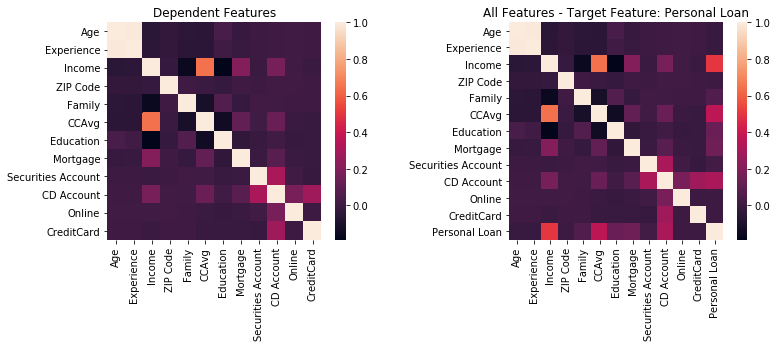

In [24]:
fig, ax =plt.subplots(1,2, figsize=(12,4))
sb.heatmap(df.iloc[:, :len(df.columns) - 1].corr(), ax=ax[0])
sb.heatmap(df.corr(), ax=ax[1])
ax[0].set_title("Dependent Features")
ax[1].set_title("All Features - Target Feature: Personal Loan")
plt.subplots_adjust(wspace=0.5)
plt.show()

Dependent feature heatmap to identify multicollinearity
>Income is strongly (negatively) correlated to Family, CCAvg, and Education
>CCAvg is moderately (negatively) correlated to Family and Education
>Age is strongly (positively) correlated to Experience
>The majority of features have a little correlation with each other

Feature heatmap to identify correlation between dependent features and our target feature (Personal Loan)
>Income, CCAvg, and CD Account have the highest correlation with the target feature

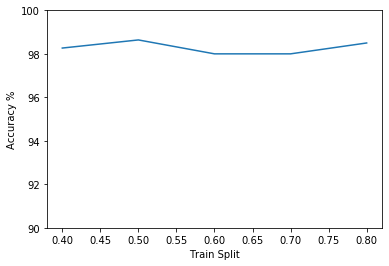

In [29]:
fig = plt.figure()
plt.plot(train_sizes, accuracy)
plt.xlabel('Train Split')
plt.ylabel('Accuracy %')
plt.ylim((90,100))
plt.show()

## Model Evaluation

The accuracy of the model is 98.2% over the test set, and 98.98% over the train set. It makes sense that the model would be more accurate over the train set, because that's what the model was created from. However it has to be noted that the difference between the two accuracies is almost negligably small, and there is some variance depending on how the data was split that run - sometimes test has greater accuracy, but they are both always over 97%. 

The accuracy of the model with unlimited (arbitrarily set to 1000) depth is 98%. It is on the lower end of accuracies compared to the other data gathered, but low is a relative term, because 98% is still extremely high.

Maximum depths between 2-8 were tested:

Max depth: 2, Accuracy: 97%
Max depth: 4, Accuracy: 98%
Max depth: 6, Accuracy: 98.4%
Max depth: 8, Accuracy: 97.75%

This was run multiple times during the testing process, and the result was always that a max depth of 6 has the overall highest accuracy. However, these are all very high accuracies, and aren't far off from a depth of 1000, so depth did not make a big difference in accuracy variance.

I tested the model on another dataset (Iris) that has more samples than the tennis dataset, making it a better indication of model accuracy. The average accuracy when run 50 times was 94%. The fact that the model has an accuracy above 90% for significantly different datasets is a good indication that overfitting is not a problem.

Splitting test and train between 40-60 vs 20-80 did not have a large difference in accuracy. A split around 60% train and 40% test has the overall highest accuracy, with smaller or larger splits both having lower accuracies. A slightly uneven split favoring train yields the best results.

# References
#### ->I'll be honest, I should have started this assignment sooner so I would have time to ask you for help, and that is what I will do in the future. I was really struggling translating the theory and high concept we've learned and talked about in class into practical code. I found this resource https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/, and followed along with the methodology and logic, and have translated that into my own work. Following their implementation is what taught me how to go about representing decision tree logic in code, and I can say that I 100% understand what I have written and how I implemented this algorithm. 
#### ->Resource used for explanation of the Gini Index formula: https://www.kdnuggets.com/2020/02/decision-tree-intuition.html